In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4,5,6,7,8,9'

In [ ]:
from compass import ScoreBasedInferenceModel as SBIm
from src.metrics import PosteriorCoverage
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches as patches
import seaborn as sns

import numpy as np
import torch
from torch.utils.data import DataLoader

from scipy.stats import norm, gaussian_kde
from scipy import optimize

import tarp

import os

%matplotlib inline

/export/home/bguenes/anaconda3/envs/simformer_torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [3]:
# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    # Remove H from Elements
    y = np.delete(y, 2, 1)

    return x, y

In [4]:
"""
# --- Load in training data ---
path_training = os.getcwd() + '/data/Chempy_data/chempy_TNG_train_data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']

train_x, train_y = clean_data(train_x, train_y)

# convert to torch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)

# --- add noise ---
pc_ab = 5 # percentage error in abundance

train_y_err = torch.ones_like(train_y)*float(pc_ab)/100.
train_y = norm.rvs(loc=train_y,scale=train_y_err)
train_y = torch.tensor(train_y).float()

train_data = torch.cat((train_x, train_y), 1)
"""

"\n# --- Load in training data ---\npath_training = os.getcwd() + '/data/Chempy_data/chempy_TNG_train_data.npz'\ntraining_data = np.load(path_training, mmap_mode='r')\n\nelements = training_data['elements']\ntrain_x = training_data['params']\ntrain_y = training_data['abundances']\n\ntrain_x, train_y = clean_data(train_x, train_y)\n\n# convert to torch tensors\ntrain_x = torch.tensor(train_x, dtype=torch.float32)\ntrain_y = torch.tensor(train_y, dtype=torch.float32)\n\n# --- add noise ---\npc_ab = 5 # percentage error in abundance\n\ntrain_y_err = torch.ones_like(train_y)*float(pc_ab)/100.\ntrain_y = norm.rvs(loc=train_y,scale=train_y_err)\ntrain_y = torch.tensor(train_y).float()\n\ntrain_data = torch.cat((train_x, train_y), 1)\n"

In [5]:
# ---  Load in the validation data ---
path_test = os.getcwd() + '/data/Chempy_model_comp_data/chempy_442_val.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']

val_x, val_y = clean_data(val_x, val_y)

# convert to torch tensors
val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)

# --- add noise ---
pc_ab = 5 # percentage error in abundance

val_y_err = torch.ones_like(val_y)*float(pc_ab)/100.
val_y = norm.rvs(loc=val_y,scale=val_y_err)
val_y = torch.tensor(val_y).float()

val_data = torch.cat((val_x, val_y), 1)

## Define ModelTransfuser

In [6]:
# Define the ModelTransfuser
model = SBIm.load('data/models/chempy_442/Model_checkpoint.pt')

## Forward Diffusion

In [7]:
"""
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

t = torch.linspace(0, 1, T)
color = ['red', 'blue', 'green', 'purple', 'orange', 'black']

def animate(i):
    data_t = model.forward_diffusion_sample(train_data[:,:6], t[i])
    plt.cla()
    for n in range(data_t.shape[1]):
        plt.hist(data_t[:,n], bins=500, range=(-5,15), density=True, alpha=0.5, color=color[n])
    plt.xlim([-5,15])
    plt.ylim([0,1])
    plt.title(f"t={int(i)}")

"""
#ani = matplotlib.animation.FuncAnimation(fig, animate, frames=model.timesteps)

#writer = matplotlib.animation.PillowWriter(fps=20,
#                                metadata=dict(artist='Me'),
#                                bitrate=1800)
#ani.save('plots/theta_to_noise.gif', writer=writer)
"""
matplotlib.animation.FuncAnimation(fig, animate, frames=model.timesteps)
"""

'\nmatplotlib.animation.FuncAnimation(fig, animate, frames=model.timesteps)\n'

## Sampling

In [8]:
mask = torch.zeros_like(val_data[0])
mask[6:] = 1

data = val_data[:1000, mask.type(torch.bool)]

In [9]:
test_index=1

In [10]:
data[0].shape

torch.Size([8])

In [11]:
err = torch.tensor([0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05]) * data[test_index].abs()

In [12]:
err

tensor([0.0022, 0.0004, 0.0021, 0.0028, 0.0119, 0.0214, 0.0135, 0.0158])

In [13]:
data[test_index].shape

torch.Size([8])

In [24]:
p0 = model.sample(x=data[test_index], err=err, device="cuda:0", timesteps=100, cfg_alpha=None, save_trajectory=True, corrector_steps=5, corrector_steps_interval=5, final_corrector_steps=10).to("cpu")

100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


In [25]:
def map_kde(samples):
    """Find the joint mode of the multivariate distribution"""
    s = samples.numpy()
    kde = gaussian_kde(s.T)  # KDE expects (n_dims, n_samples)
    
    # Start optimization from the mean
    initial_guess = np.mean(s, axis=0)
    
    # Use full minimize with multiple dimensions
    result = optimize.minimize(lambda x: -kde(x.reshape(-1, 1)), initial_guess)
    std_devs = np.sqrt(np.diag(kde.covariance))

    return result.x, std_devs

In [26]:
# map, std = map_kde(p[0,:,:6])
# print(map)
# print(std)

In [27]:
# print(p.mean(axis=1)[0,:6])
# print(p.std(axis=1)[0,:6])

In [28]:
map0, std0 = map_kde(p0[0,:,:6])
print(map0)
print(std0)

[-2.41648986 -2.95206689  0.14095431  0.54433738  0.46719883  6.54264977]
[0.07456976 0.09215818 0.15636592 0.06575497 0.06879376 1.23159784]


In [29]:
print(p0.mean(axis=1)[0,:6])
print(p0.std(axis=1)[0,:6])

tensor([-2.4462, -3.0674, -0.0572,  0.5420,  0.4709,  7.4969])
tensor([0.1488, 0.1839, 0.3120, 0.1312, 0.1373, 2.4574])


In [30]:
val_data[test_index]

tensor([-2.4600, -2.9821, -0.1224,  0.4469,  0.6418,  7.8358,  0.0450, -0.0085,
        -0.0419,  0.0557,  0.2377,  0.4290,  0.2708,  0.3158])

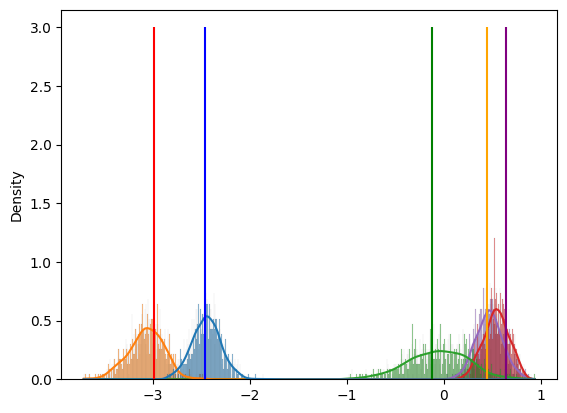

In [31]:
sns.histplot(p0[0,:,:5].detach().numpy(), bins=1000, kde=True,color=['blue','red','green','orange','purple'], legend=False, stat='density')
plt.vlines(val_data[test_index,:5], 0, 3, color=['blue','red','green','orange','purple'])
#plt.vlines(val_data[1,0], 0, 10, color='red')
plt.show()

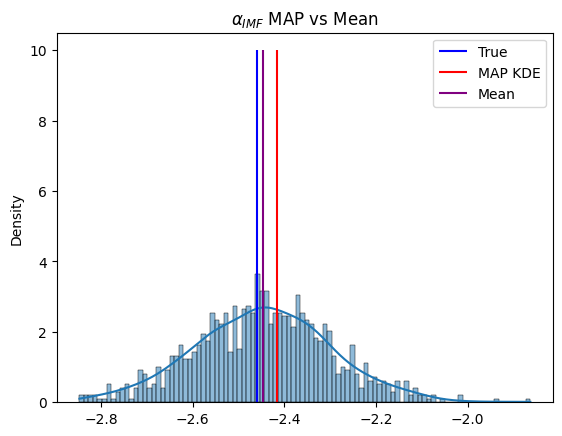

In [32]:
sns.histplot(p0[0,:,:1].detach().numpy(), bins=100, kde=True,color="black", legend=False, stat='density')
plt.vlines(val_data[test_index,:1], 0, 10, color="blue", label="True")
plt.vlines(map0[0],0,10, color="red", label="MAP KDE")
plt.vlines(p0.mean(1)[0,0],0,10,color="purple", label="Mean")
plt.title(r"$\alpha_{IMF}$ MAP vs Mean")
plt.legend()
plt.show()

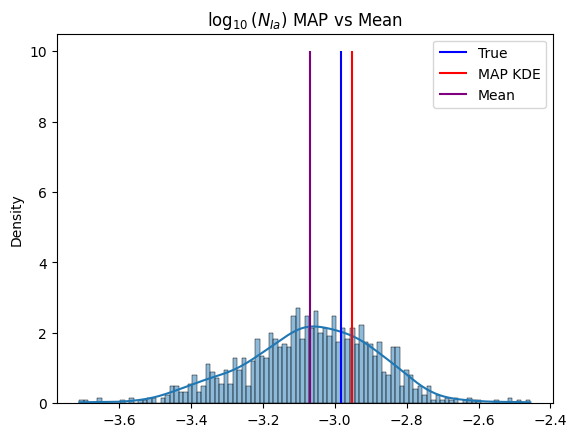

In [33]:
sns.histplot(p0[0,:,1:2].detach().numpy(), bins=100, kde=True,color="black", legend=False, stat='density')
plt.vlines(val_data[test_index,1:2], 0, 10, color="blue", label="True")
plt.vlines(map0[1],0,10, color="red", label="MAP KDE")
plt.vlines(p0.mean(1)[0,1],0,10,color="purple", label="Mean")
plt.title(r"$\log_{10}(N_{Ia})$ MAP vs Mean")
plt.legend()
plt.show()

In [34]:
"""
plt.rcParams["animation.html"] = "jshtml"
#plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

t = torch.linspace(0, 1, model.timesteps)
color = ['red', 'blue', 'green', 'purple', 'orange', 'black']

def animate(i):
    #data_t = model.forward_diffusion_sample(train_data[:,:6], t[i])
    data_t = model.x_t[0,i,:,:6].detach().numpy()
    plt.cla()
    for n in range(data_t.shape[1]):
        plt.hist(data_t[:,n], bins=500, range=(-5,15), density=True, alpha=0.5, color=color[n])
    plt.xlim([-5,15])
    plt.ylim([0,1])
    plt.title(f"t={int(i)}")
"""
"""
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=model.timesteps)

writer = matplotlib.animation.PillowWriter(fps=20,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('../plots/theta_to_noise.gif', writer=writer)
"""
# matplotlib.animation.FuncAnimation(fig, animate, frames=model.timesteps)

"\nani = matplotlib.animation.FuncAnimation(fig, animate, frames=model.timesteps)\n\nwriter = matplotlib.animation.PillowWriter(fps=20,\n                                metadata=dict(artist='Me'),\n                                bitrate=1800)\nani.save('../plots/theta_to_noise.gif', writer=writer)\n"

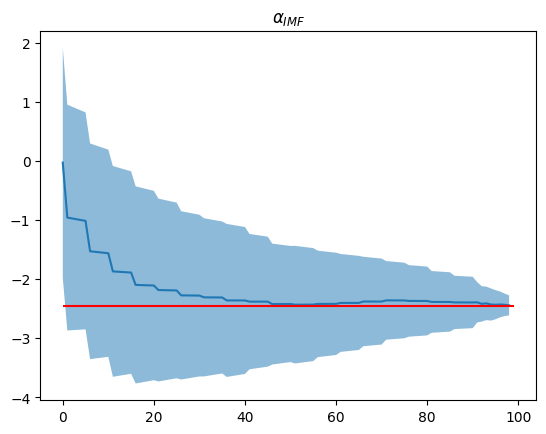

In [35]:
x = np.arange(0,model.sampler.data_t[0,:,:,0].shape[0]-1)
y = model.sampler.data_t[0,:-1,:,0].detach().numpy().mean(axis=1)
yerr = model.sampler.data_t[0,:-1,:,0].detach().numpy().std(axis=1)

plt.plot(x,y)
plt.fill_between(x, y-yerr, y+yerr, alpha=0.5)
plt.hlines(val_data[test_index,0], 0, model.sampler.data_t[0,:,:,0].shape[0]-1, color='red')
plt.title(r"$\alpha_{IMF}$")
plt.show()

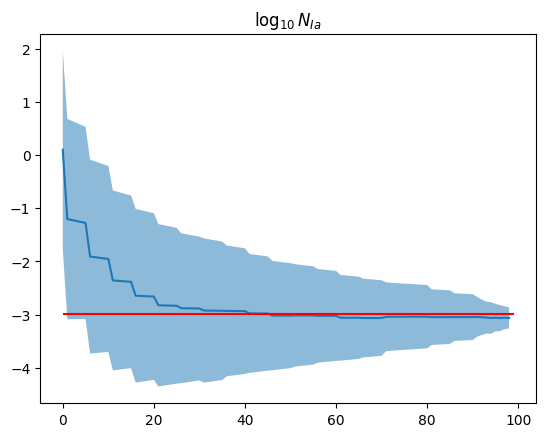

In [36]:
x = np.arange(0,model.sampler.data_t[0,:,:,0].shape[0]-1)
y = model.sampler.data_t[0,:-1,:,1].detach().numpy().mean(axis=1)
yerr = model.sampler.data_t[0,:-1,:,1].detach().numpy().std(axis=1)

plt.plot(x,y)
plt.fill_between(x, y-yerr, y+yerr, alpha=0.5)
plt.hlines(val_data[test_index,1], 0, model.sampler.data_t[0,:,:,0].shape[0]-1, color='red')
plt.title(r"$\log_{10}N_{Ia}$")
plt.show()

In [25]:
# denoising_data = model.sampler.data_t.detach().numpy()

# plt.rcParams["animation.html"] = "jshtml"
# plt.rcParams['figure.dpi'] = 100 
# plt.ioff()
# fig, ax = plt.subplots()

# def animate(i):
#     plt.clf()
#     plt.xlim(-3,-1)
#     plt.ylim(-3.5,-1.5)
#     plt.xlabel(r'$\alpha_{IMF}$')
#     plt.ylabel(r'$\log_{10}N$')
#     plt.title(f'Denoising Timestep: {i}')
    
#     sns.set_style("white")
#     sns.kdeplot(x=denoising_data[0,i,:,0], y=denoising_data[0,i,:,1], cmap='Blues', fill=True, bw_adjust=0.6, levels=100)
#     plt.tight_layout()

# ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=model.sampler.timesteps) 

# writer = matplotlib.animation.PillowWriter(fps=10,
#                                 bitrate=-1)

# ani2.save('plots/Readme/denoising_dmp1.gif', writer=writer)


In [26]:
# plt.rcParams["animation.html"] = "jshtml"
# plt.rcParams['figure.dpi'] = 100  
# plt.ioff()
# fig, ax = plt.subplots()

# def x_dx(i, denoising_data, t):
#     x = denoising_data[0,t,:5,i]
#     dx = x - denoising_data[0,t+1,:5,i]
#     return x, dx

# def animate(t):
#     plt.clf()
#     plt.xlim(-5,5)
#     plt.ylim(-5,5)
#     plt.xlabel(r'$\alpha_{IMF}$')
#     plt.ylabel(r'$\log_{10}N$')
#     plt.title(f'Denoising Timestep: {t+1}')

#     if t > 1:
#         x, dx = x_dx(0, denoising_data, t-1)
#         y, dy = x_dx(1, denoising_data, t-1)
#         plt.quiver(x, y, -dx, -dy, scale=1, scale_units='xy', width=0.003, color=['red','blue','green','orange','purple'])
#         plt.scatter(x, y, s=20, marker='x', color=['red','blue','green','orange','purple'])
#     if t < model.sampler.timesteps-1:
#         x, dx = x_dx(0, denoising_data, t)
#         y, dy = x_dx(1, denoising_data, t)

#         plt.quiver(x, y, -dx, -dy, scale=1, scale_units='xy', width=0.003, color=['red','blue','green','orange','purple'])
#         plt.scatter(x, y, s=20, marker='x', color=['red','blue','green','orange','purple'])

#     plt.tight_layout()

# ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=model.sampler.timesteps) 

# writer = matplotlib.animation.PillowWriter(fps=10,
#                                 bitrate=-1)
# ani2.save('plots/Readme/denoising_dpm2.gif', writer=writer)

In [62]:
p3 = model.sample(x=data[:10], err=err, device="cuda", timesteps=100, cfg_alpha=None, final_corrector_steps=5, corrector_steps=5).to("cpu")

100%|██████████| 2/2 [00:04<00:00,  2.38s/it]


In [63]:
p3

tensor([[[-1.5910, -2.9699,  0.5991,  0.4396,  0.5738,  4.5597],
         [-2.0358, -2.8932, -0.1230,  0.7276,  0.6774,  6.3128],
         [-1.9111, -3.4002, -0.4394,  0.5490,  0.7197, 10.4942],
         ...,
         [-2.2033, -3.5954, -0.4049,  0.7519,  0.4936, 10.0684],
         [-2.3457, -3.7637, -0.3447,  0.6181,  0.6617, 11.0106],
         [-1.9776, -3.0468, -0.7011,  0.6802,  0.5226,  8.4529]],

        [[-2.6906, -2.9169, -0.3023,  0.5461,  0.6127,  6.9935],
         [-2.6292, -3.2088, -0.0474,  0.5863,  0.8182, 10.8715],
         [-2.0291, -3.0188, -0.4701,  0.3523,  0.3843, 10.2775],
         ...,
         [-2.6330, -2.8978,  0.1992,  1.0377,  0.5015,  9.1157],
         [-2.3596, -3.2281,  0.1358,  0.7785,  0.5099,  8.7226],
         [-2.3753, -3.0675,  0.0597,  0.3836,  0.4646,  4.8367]],

        [[-2.2065, -2.5288, -0.2170,  0.6840,  0.4488,  6.4144],
         [-2.0923, -2.8395, -0.3464,  0.6703,  0.4560,  7.8169],
         [-2.3037, -2.7416, -0.2566,  0.3185,  0.3715,  7.

In [64]:
def _map_kde(samples):
    """Find the joint mode of the multivariate distribution"""
    kde = gaussian_kde(samples.T)  # KDE expects (n_dims, n_samples)
    
    # Start optimization from the mean
    initial_guess = np.mean(samples, axis=0)
    
    # Use full minimize with multiple dimensions
    result = optimize.minimize(lambda x: -kde(x.reshape(-1, 1)), initial_guess)
    std_devs = np.sqrt(np.diag(kde.covariance))

    return result.x, std_devs

In [65]:
posterior_samples = p3.numpy()
a = torch.tensor([_map_kde(posterior_samples[i]) for i in range(len(posterior_samples))])

KeyboardInterrupt: 

In [66]:
torch.mean(100*torch.abs((val_data[:10,:6]-p3.mean(axis=1))/val_data[:10,:6]), axis=0)

tensor([  3.7528,   5.2244, 103.7407,  10.7003,  14.2803,  30.1707])

In [67]:
maps = np.array([map_kde(p3[i,:,:6])[0] for i in range(len(p3))])

In [59]:
maps

array([[-1.95108429, -3.21378467, -0.20328029,  0.5444991 ,  0.42866042,
         9.0899789 ],
       [-2.38160481, -2.96445105,  0.06485691,  0.53747998,  0.4229124 ,
         5.37648882],
       [-2.28961103, -2.75732815, -0.12844328,  0.48672657,  0.41213492,
         8.5400312 ],
       [-1.7247689 , -2.95380891, -0.20892806,  0.54548752,  0.47278433,
         6.52753548],
       [-2.4404414 , -2.34893178, -0.3053967 ,  0.48779061,  0.43436587,
         8.95796656],
       [-2.04682627, -2.22960905, -0.21444838,  0.50476345,  0.4265618 ,
         8.82924502],
       [-2.20328698, -3.18133333, -0.34372748,  0.61190433,  0.49667801,
         2.42373756],
       [-2.09695833, -2.82343734, -0.32594635,  0.58596149,  0.46460353,
         1.82252973],
       [-2.27058505, -2.48381895, -0.08242887,  0.51795452,  0.4732216 ,
         7.53079414],
       [-2.72928667, -2.62995997, -0.20474978,  0.54832635,  0.47563485,
         4.74813044]])

In [61]:
torch.mean(100*torch.abs((val_data[:10,:6]-maps)/val_data[:10,:6]),axis=0)

tensor([ 4.1736,  5.7801, 99.5401,  8.7815, 17.2294, 32.8465],
       dtype=torch.float64)

In [68]:
torch.mean(100*torch.abs((val_data[:10,:6]-maps)/val_data[:10,:6]),axis=0)

tensor([  4.4945,   4.3551, 135.0518,  11.3618,  13.9064,  29.8934],
       dtype=torch.float64)

In [ ]:
def log_prob(samples, theta):
    kde = gaussian_kde(samples.T.numpy())
    return kde.logpdf(theta).item()

In [ ]:
log_probs = np.array([log_prob(p3[i,:,:6], val_data[i,:6]) for i in range(len(p3))])

In [ ]:
log_probs.min()

-26.907245872123557

In [ ]:
log_probs.argmin()

576

In [ ]:
log_probs.max()

0.894015435760365

In [ ]:
log_probs.argmax()

930

In [ ]:
np.mean(log_probs)

-13.772950630332414

In [ ]:
thetas_np=p3[:999,:,:6].numpy().transpose(1,0,2)
val_theta_np=val_data[:999,:6].numpy()

In [ ]:
val_theta_np.shape

(999, 6)

In [ ]:
thetas_np.shape

(1000, 999, 6)

In [ ]:
plot_hist = ["coverage", "histogram", "predictions", "tarp"]
labels_in = [r"$\alpha_{IMF}$", "$log_{10}N_{1a}$", "$log_{10}SFE$", "$log_{10}SFR", "$x_{out}$", "Time"]
metric = PosteriorCoverage(
    num_samples=1000, sample_method="direct",
    labels=labels_in,
    plot_list = plot_hist
)

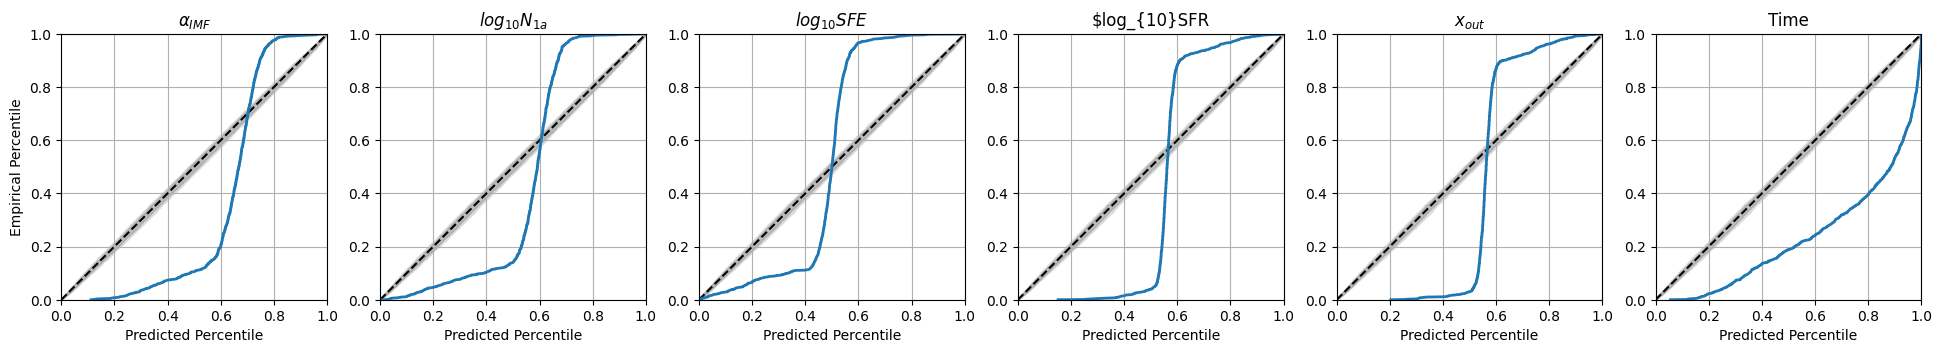

In [ ]:
metric._plot_coverage(thetas_np, val_theta_np,"")

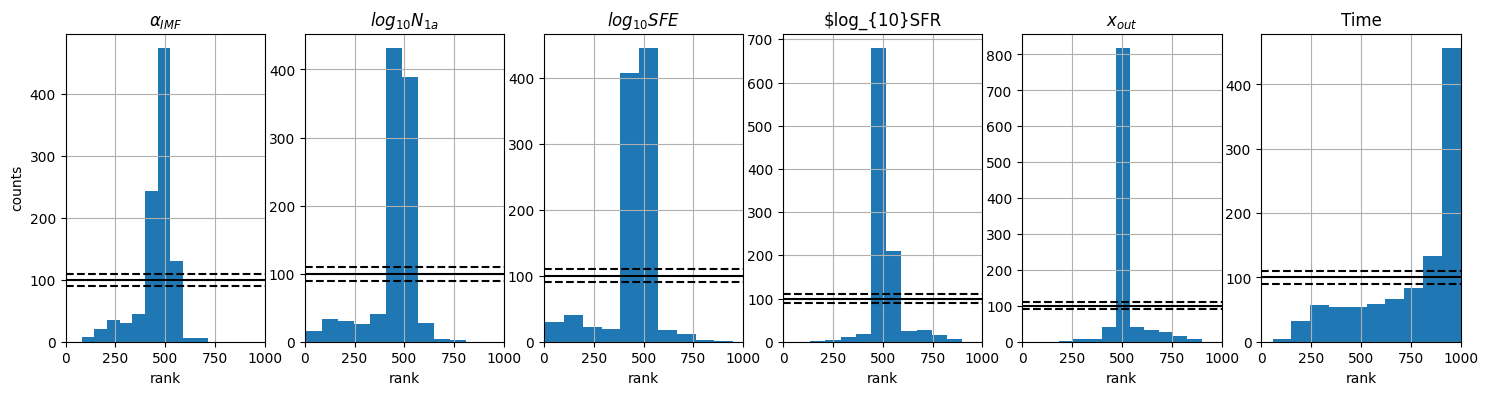

In [ ]:
metric._plot_ranks_histogram(thetas_np, val_theta_np,"")

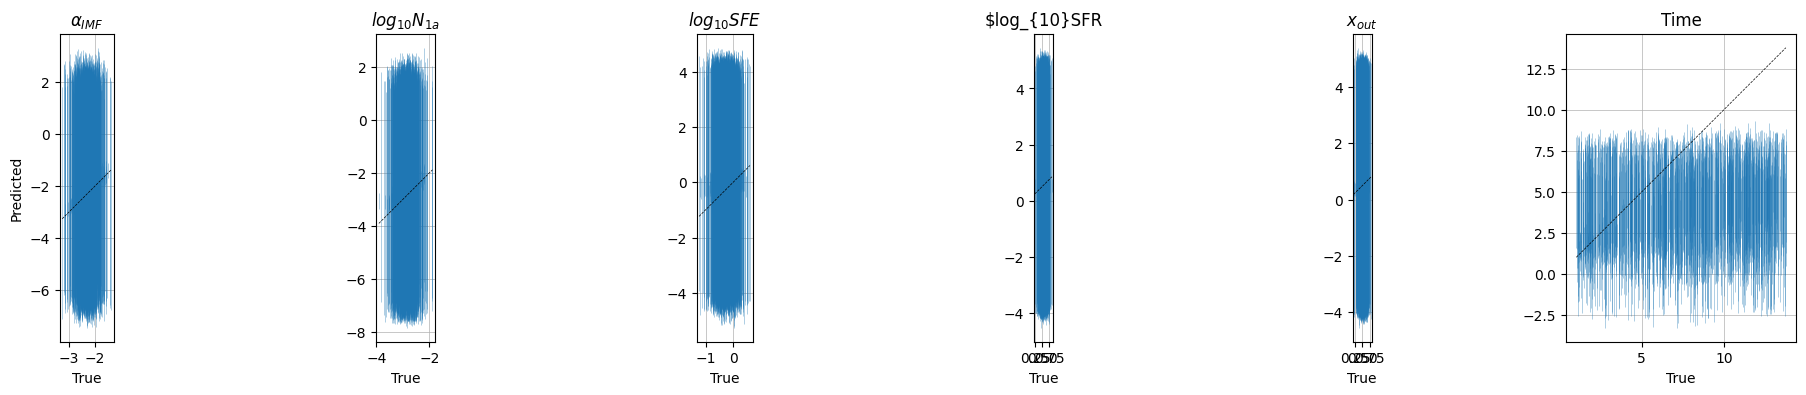

In [ ]:
metric._plot_predictions(thetas_np, val_theta_np,"")

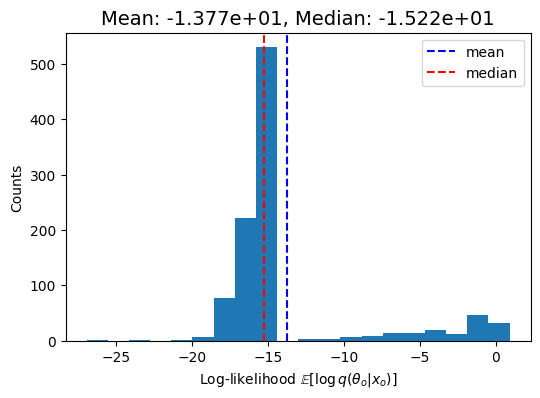

In [ ]:
metric._calc_true_logprob(thetas_np, val_theta_np,"")[0]

In [ ]:
metric._plot_TARP(thetas_np, val_theta_np,"",
                    references="random", metric="euclidean",
                    num_alpha_bins=None,
                    num_bootstrap=100,
                    norm=True, bootstrap=True)

 51%|█████     | 51/100 [00:04<00:04, 11.89it/s]


KeyboardInterrupt: 

In [ ]:
# measure tarp
ecp, alpha = tarp.get_tarp_coverage(
    thetas_np, val_theta_np,
    norm=True, bootstrap=True,
    num_bootstrap=100
)
tarp_val = np.mean(ecp[:,ecp.shape[1]//2])
tarp_diff = abs(tarp_val-0.5)

print(tarp_diff)

100%|██████████| 100/100 [00:08<00:00, 12.09it/s]

0.46414414414414407


In [ ]:
np.abs(ecp-np.linspace(0,1,ecp.shape[1])).max()

0.8437528437528438